In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
pd.set_option('display.max_rows', 60)

In [4]:
pd.set_option('display.max_columns', 100)

In [5]:
debug = True

In [6]:
# num_rows = 30000 if debug else None

In [7]:
# df = get_train_test(DATA_DIRECTORY, num_rows= num_rows)

In [8]:
NUM_THREADS = 4
DATA_DIRECTORY = "../input/"
SUBMISSION_SUFIX = "_model2_04"

In [9]:
# path = DATA_DIRECTORY
# num_rows= num_rows

In [10]:
# train = pd.read_csv('application_train.csv', nrows=num_rows)
# test = pd.read_csv('application_test.csv', nrows=num_rows)
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')

In [11]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [12]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

> 가장 먼저 해야할것은 바로 invalance 한지 확인할것

In [13]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<Axes: >

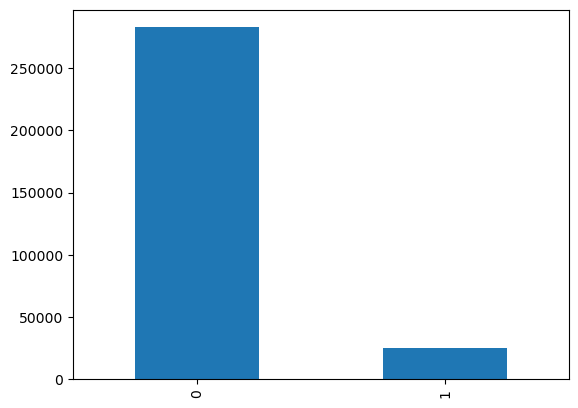

In [14]:
train['TARGET'].value_counts().plot.bar()

- train.append(test)  또는  pd.concat([train, test]) 하면 동일한 값 얻을수 있다

In [15]:
train.append(test) 

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary sp

In [16]:
df = train.append(test) 

In [17]:
del train, test;

In [18]:
gc.collect()  # gc : 파이썬의 가비지 컬렉션 모듈

32

## preprocessing

In [19]:
df['CODE_GENDER'].value_counts()

F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64

In [20]:
df[df['CODE_GENDER'] != 'XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary sp

In [21]:
df = df[df['CODE_GENDER'] != 'XNA']  # 4명밖에 없어서 제외

In [22]:
df[df['AMT_INCOME_TOTAL'] < 20000000] # Max income in test is 4M; train has a 117M value

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary sp

In [23]:
df = df[df['AMT_INCOME_TOTAL'] < 20000000] # 실제 해보니 1개제외

In [24]:
(df['DAYS_EMPLOYED'] == 365243).sum()

64648

In [25]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
# null data가 365243으로 채워져 있어서 그것을 NaN으포 채우겠다

In [26]:
df['DAYS_EMPLOYED']  # 총 몇일 일했나?

0        -637.0
1       -1188.0
2        -225.0
3       -3039.0
4       -3038.0
          ...  
48739   -5169.0
48740   -1149.0
48741   -3037.0
48742   -2731.0
48743    -633.0
Name: DAYS_EMPLOYED, Length: 356250, dtype: float64

In [27]:
[f for f in df.columns if 'FLAG_DOC' in f]

['FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [28]:
docs = [f for f in df.columns if 'FLAG_DOC' in f]

In [29]:
df[docs]

,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48740,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48741,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48742,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
df[docs].sum(axis=1)

0        1
1        1
2        0
3        1
4        1
        ..
48739    1
48740    1
48741    1
48742    1
48743    1
Length: 356250, dtype: int64

In [31]:
df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)

In [32]:
df[docs].kurtosis(axis=1)

0        20.0
1        20.0
2         0.0
3        20.0
4        20.0
         ... 
48739    20.0
48740    20.0
48741    20.0
48742    20.0
48743    20.0
Length: 356250, dtype: float64

1. 왜도 (Skewness) : 왜도라는 표현이 생소할 수 있기에 비대칭도라고 받아들이는게 쉬울 수도 있다. 데이터가 얼마나 비대칭적인지를 나타내며 왜도의 절대값이 클수록 데이터의 비대칭성이 크다. (왜도는 양의 값과 음의 값 모두 존재 가능) 쉽게 말해 절대값을 씌웠을 때 왜도의 값이 크면 → 비대칭성도 크다



2. 첨도 (Kurtosis) : 위키에 적힌 대로는 확률 분포의 꼬리가 두꺼운 정도를 나타내는 척도인데, 쉽게 풀어 설명하면 데이터에 이상치가 많은 정도라고 생각하면 된다. 첨도가 클수록 데이터 내에 이상치가 많다. (첨도 값의 범위에 따라 mesokurtic, leptokurtic, platykurtic으로 분류되는데 값이 클수록 이상치가 많다는 정도만 알아둬도 충분할 것 같다.)

​

- 결론적으로, log를 씌우게 되면 왜도와 첨도는 낮아지게 된다. 즉 비대칭적이고, 이상치가 많은 데이터의 경우 log를 씌우면 좀 더 다루기 쉬워진다고 생각하면 될 것 같다.


<Axes: >

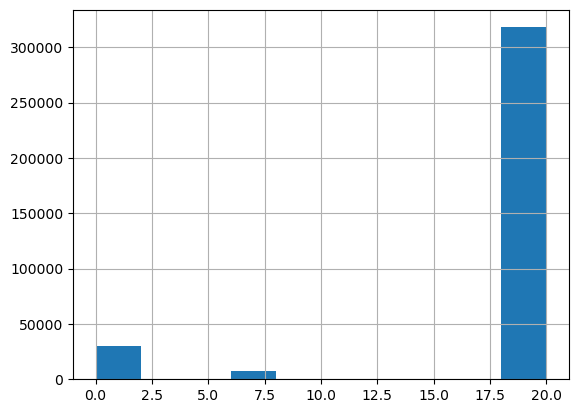

In [33]:
df[docs].kurtosis(axis=1).hist()

In [34]:
df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)

In [35]:

def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [36]:
df['DAYS_BIRTH']

0        -9461
1       -16765
2       -19046
3       -19005
4       -19932
         ...  
48739   -19970
48740   -11186
48741   -15922
48742   -13968
48743   -13962
Name: DAYS_BIRTH, Length: 356250, dtype: int64

In [37]:
- df['DAYS_BIRTH'] / 365

0        25.920548
1        45.931507
2        52.180822
3        52.068493
4        54.608219
           ...    
48739    54.712329
48740    30.646575
48741    43.621918
48742    38.268493
48743    38.252055
Name: DAYS_BIRTH, Length: 356250, dtype: float64

In [38]:
df['DAYS_BIRTH'].apply(lambda x: get_age_label(x)) # label 화

0        1
1        3
2        4
3        4
4        4
        ..
48739    4
48740    2
48741    3
48742    2
48743    2
Name: DAYS_BIRTH, Length: 356250, dtype: int64

In [39]:
df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

In [40]:
df['EXT_SOURCE_1']

0        0.083037
1        0.311267
2             NaN
3             NaN
4             NaN
           ...   
48739         NaN
48740         NaN
48741    0.733503
48742    0.373090
48743         NaN
Name: EXT_SOURCE_1, Length: 356250, dtype: float64

In [41]:
df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']

0        0.021834
1        0.193685
2             NaN
3             NaN
4             NaN
           ...   
48739         NaN
48740         NaN
48741    0.464139
48742    0.166287
48743         NaN
Length: 356250, dtype: float64

In [42]:
df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

0        0.003043
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
48739         NaN
48740         NaN
48741    0.131682
48742    0.099016
48743         NaN
Length: 356250, dtype: float64

#### New features based on External sources

In [43]:
df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

In [44]:
df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3 
# 캐글러가 해보니 가장 좋은 조합...

0        0.847150
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
48739         NaN
48740         NaN
48741    2.950912
48742    2.978250
48743         NaN
Length: 356250, dtype: float64

In [45]:
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

In [46]:
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())

In [47]:
feature_name

'EXT_SOURCES_VAR'

In [48]:
eval('np.{}'.format(function_name)) # 이거는 np.var 과 같은 것

<function numpy.var(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>, *, where=<no value>)>

In [49]:
np.var

<function numpy.var(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>, *, where=<no value>)>

In [50]:
eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

0        0.005646
1        0.024177
2        0.007539
3        0.000000
4        0.000000
           ...   
48739    0.000008
48740    0.000000
48741    0.037145
48742    0.008572
48743    0.008501
Length: 356250, dtype: float64

In [51]:
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    df[feature_name] = eval('np.{}'.format(function_name))(
        df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [52]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOCUMENT_COUNT,NEW_DOC_KURT,AGE_RANGE,EXT_SOURCES_PROD,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1,20.0,1,0.003043,0.083037,0.262949,0.161787,0.139376,0.005646
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,20.0,3,NaN,0.311267,0.622246,0.466757,0.466757,0.024177
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,4,NaN,0.555912,0.729567,0.642739,0.642739,0.007539
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,20.0,4,NaN,0.650442,0.650442,0.650442,0.650442,0.000000
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,

#### Credit ratios

In [53]:
 df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
         # CREDIT : 융자 /  ANNUITY : 연금  --- 수입대비면 빚이 얼마냐?

In [54]:
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

#### Income ratios

In [55]:
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

In [56]:
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

In [57]:
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']

In [58]:
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']

#### Time ratios

In [59]:
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

## Groupby: Statistics for applications in the same group

In [60]:
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']

In [61]:
df, group_cols, counted, agg_name = df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN'

In [62]:
group_cols 

['ORGANIZATION_TYPE',
 'NAME_EDUCATION_TYPE',
 'OCCUPATION_TYPE',
 'AGE_RANGE',
 'CODE_GENDER']

In [63]:
group_cols + [counted]

['ORGANIZATION_TYPE',
 'NAME_EDUCATION_TYPE',
 'OCCUPATION_TYPE',
 'AGE_RANGE',
 'CODE_GENDER',
 'EXT_SOURCES_MEAN']

- 피쳐들이 많기 때문에 필요한 피쳐만 가져와서 따로 만들필요가 있다
- 이때 groupby를 해서...

In [64]:
df[group_cols + [counted]] 

,ORGANIZATION_TYPE,NAME_EDUCATION_TYPE,OCCUPATION_TYPE,AGE_RANGE,CODE_GENDER,EXT_SOURCES_MEAN
0,Business Entity Type 3,Secondary / secondary special,Laborers,1,M,0.161787
1,School,Higher education,Core staff,3,F,0.466757
2,Government,Secondary / secondary special,Laborers,4,M,0.642739
3,Business Entity Type 3,Secondary / secondary special,Laborers,4,F,0.650442
4,Religion,Secondary / secondary special,Core staff,4,M,0.322738
...,...,...,...,...,...,...
48739,Other,Secondary / secondary special,NaN,4,F,0.645800
48740,Trade: type 7,Secondary / secondary special,Sales staff,2,F,0.684596
48741,Business Entity Type 3,Secondary / secondary special,NaN,3,F,0.549995
48742,Self-employed,Higher education,Managers,2,M,0.471416


In [65]:
df[group_cols + [counted]].groupby(group_cols)

- group_cols + [counted]의 df를 가져와서 group_cols로 groupby하여 counted인 EXT_SOURCES_MEAN를 agg_해서 평균으로 변환후(mean()) reset_index해서 저장하고 rename은 GROUP_EXT_SOURCES_MEDIAN로 해서 df에 저장

In [66]:
# df, group_cols, counted, agg_name = df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN'
df[group_cols + [counted]].groupby(group_cols)[counted].mean()


ORGANIZATION_TYPE  NAME_EDUCATION_TYPE            OCCUPATION_TYPE       AGE_RANGE  CODE_GENDER
Advertising        Academic degree                Drivers               4          M              0.227486
                   Higher education               Accountants           2          F              0.570636
                                                                        3          F              0.641871
                                                                        4          F              0.659526
                                                  Cleaning staff        4          F              0.499534
                                                                                                    ...   
University         Secondary / secondary special  Security staff        4          M              0.549713
                                                  Waiters/barmen staff  2          F              0.518151
                                                 

In [67]:
df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index()

,ORGANIZATION_TYPE,NAME_EDUCATION_TYPE,OCCUPATION_TYPE,AGE_RANGE,CODE_GENDER,EXT_SOURCES_MEAN
0,Advertising,Academic degree,Drivers,4,M,0.227486
1,Advertising,Higher education,Accountants,2,F,0.570636
2,Advertising,Higher education,Accountants,3,F,0.641871
3,Advertising,Higher education,Accountants,4,F,0.659526
4,Advertising,Higher education,Cleaning staff,4,F,0.499534
...,...,...,...,...,...,...
9240,University,Secondary / secondary special,Security staff,4,M,0.549713
9241,University,Secondary / secondary special,Waiters/barmen staff,2,F,0.518151
9242,University,Secondary / secondary special,Waiters/barmen staff,3,F,0.585908
9243,University,Secondary / secondary special,Waiters/barmen staff,4,F,0.534677


In [68]:
df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted: agg_name})

,ORGANIZATION_TYPE,NAME_EDUCATION_TYPE,OCCUPATION_TYPE,AGE_RANGE,CODE_GENDER,GROUP_EXT_SOURCES_MEDIAN
0,Advertising,Academic degree,Drivers,4,M,0.227486
1,Advertising,Higher education,Accountants,2,F,0.570636
2,Advertising,Higher education,Accountants,3,F,0.641871
3,Advertising,Higher education,Accountants,4,F,0.659526
4,Advertising,Higher education,Cleaning staff,4,F,0.499534
...,...,...,...,...,...,...
9240,University,Secondary / secondary special,Security staff,4,M,0.549713
9241,University,Secondary / secondary special,Waiters/barmen staff,2,F,0.518151
9242,University,Secondary / secondary special,Waiters/barmen staff,3,F,0.585908
9243,University,Secondary / secondary special,Waiters/barmen staff,4,F,0.534677


In [69]:
df[group_cols + [counted]].groupby(group_cols)[counted].median()

ORGANIZATION_TYPE  NAME_EDUCATION_TYPE            OCCUPATION_TYPE       AGE_RANGE  CODE_GENDER
Advertising        Academic degree                Drivers               4          M              0.227486
                   Higher education               Accountants           2          F              0.540285
                                                                        3          F              0.647053
                                                                        4          F              0.696032
                                                  Cleaning staff        4          F              0.499534
                                                                                                    ...   
University         Secondary / secondary special  Security staff        4          M              0.555836
                                                  Waiters/barmen staff  2          F              0.518151
                                                 

In [70]:
df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index()

,ORGANIZATION_TYPE,NAME_EDUCATION_TYPE,OCCUPATION_TYPE,AGE_RANGE,CODE_GENDER,EXT_SOURCES_MEAN
0,Advertising,Academic degree,Drivers,4,M,0.227486
1,Advertising,Higher education,Accountants,2,F,0.540285
2,Advertising,Higher education,Accountants,3,F,0.647053
3,Advertising,Higher education,Accountants,4,F,0.696032
4,Advertising,Higher education,Cleaning staff,4,F,0.499534
...,...,...,...,...,...,...
9240,University,Secondary / secondary special,Security staff,4,M,0.555836
9241,University,Secondary / secondary special,Waiters/barmen staff,2,F,0.518151
9242,University,Secondary / secondary special,Waiters/barmen staff,3,F,0.576553
9243,University,Secondary / secondary special,Waiters/barmen staff,4,F,0.523882


In [71]:
df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})

,ORGANIZATION_TYPE,NAME_EDUCATION_TYPE,OCCUPATION_TYPE,AGE_RANGE,CODE_GENDER,GROUP_EXT_SOURCES_MEDIAN
0,Advertising,Academic degree,Drivers,4,M,0.227486
1,Advertising,Higher education,Accountants,2,F,0.540285
2,Advertising,Higher education,Accountants,3,F,0.647053
3,Advertising,Higher education,Accountants,4,F,0.696032
4,Advertising,Higher education,Cleaning staff,4,F,0.499534
...,...,...,...,...,...,...
9240,University,Secondary / secondary special,Security staff,4,M,0.555836
9241,University,Secondary / secondary special,Waiters/barmen staff,2,F,0.518151
9242,University,Secondary / secondary special,Waiters/barmen staff,3,F,0.576553
9243,University,Secondary / secondary special,Waiters/barmen staff,4,F,0.523882


In [72]:
gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})

In [73]:
df = df.merge(gp, on=group_cols, how='left')

In [74]:
del gp

In [75]:
gc.collect()

0

In [76]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [77]:
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')


## Encode categorical features (LabelEncoder)

In [78]:
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns

In [79]:
df, le_encoded_cols = label_encoder(df, None)

In [81]:
le_encoded_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [82]:
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOCUMENT_COUNT,NEW_DOC_KURT,AGE_RANGE,EXT_SOURCES_PROD,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,CREDIT_TO_INCOME_RATIO,INCOME_TO_EMPLOYED_RATIO,INCOME_TO_BIRTH_RATIO,EMPLOYED_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,GROUP_EXT_SOURCES_MEDIAN_x,GROUP_EXT_SOURCES_MEDIAN_y,GROUP_EXT_SOURCES_STD,GROUP_INCOME_MEAN,GROUP_INCOME_STD,GROUP_CREDIT_TO_ANNUITY_MEAN,GROUP_CREDIT_TO_ANNUITY_STD,GROUP_CREDIT_MEAN,GROUP_ANNUITY_MEAN,GROUP_ANNUITY_STD
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,0,0,0,0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,0,1.0,2,2,0,10,0,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1,20.0,1,0.003043,0.083037,0.262949,0.161787,0.139376,0.005646,16.461104,1.158397,0.121978,2.007889,-317.896389,-21.403657,0.067329,0.224078,NaN,NaN,0.119860,0.360779,0.364994,0.142491,160036.755599,59460.725162,17.153770,6.189382,423946.077897,24847.926485,12190.206798
1,100003,0.0,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,1,1,1,1,0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,1,2.0,1,1,1,11,0,0,0,0,0,0,1,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,20.0,3,NaN,0.311267,0.622246,0.466757,0.466757,0.024177,36.234085,1.145199,0.132217,4.790750,-227.272727,-16.104981,0.070862,0.017358,NaN,NaN,0.049389,0.570305,0.584520,0.123997,172829.868996,70033.742264,23.424574,8.206111,717295.519651,29831.965939,15037.721692
2,100004,0.0,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0,0,0,0,0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,0,1.0,2,2,1,9,0,0,0,0,0,0,2,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,4,NaN,0.555912,0.729567,0.642739,0.642739,0.007539,20.000000,1.000000,0.100000,2.000000,-300.000000,-3.544051,0.011814,0.132889,-0.001365,-0.115556,0.042791,0.538238,0.566254,0.148321,167040.833333,76323.420579,22.821931,7.567490,627030.309524,27408.857143,13448.587113
3,100006,0.0,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0,0,0,2,0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,0,2.0,2,2,0,17,0,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,20.0,4,NaN,0.650442,0.650442,0.650442,0.650442,0.000000,10.532818,1.052803,0.219900,2.316167,-44.422507,-7.103394,0.159905,0.128229,NaN,NaN,0.032465,0.543694,0.567053,0.142056,155682.406431,66157.804465,22.282704,7.737152,602336.162211,26623.157514,12942.189239
4,100007,0.0

In [83]:


def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [84]:
df, le_encoded_cols = label_encoder(df, None)
df = drop_application_columns(df)

In [85]:
df.shape

(356250, 83)